In [25]:
import numpy as np
import pandas as pd

#!pip install pyEDFlib
import pyedflib
#!pip install ipympl

from scipy.fftpack import fft, ifft, fftfreq
from scipy import signal as sg
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic, entropy, norm
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import sys
import os
import time
#import pickle
import dill as pickle

import concurrent.futures
from numba import jit, njit, prange

from tqdm.notebook import tqdm
from collections import defaultdict
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display
sns.set(context='notebook', style='ticks', palette='bright', font='sans-serif', font_scale=1, color_codes=True, rc=None)
plt.rcParams['figure.figsize'] = (10, 6)

#print("SYS.PATH: ", sys.path[:3])
#sys.path.insert(0, r"C:\Users\User\[[Python]]\[AlexeyT]\PAC_PROJECT")

from utility_functions import *
#from class_lfp import LFP
#from class_pac import MyPAC
#from class_patient import Patient
%run utility_functions.py
%run lfp_class.py
%run pac_class.py
%run patient_class.py

print("Succesfully imported libraries and modules\n")

Succesfully imported libraries and modules



## N:M Phase Synchronization

### Loading example patient (3)

In [26]:
with open("path_data.txt") as f:
    data_dir = f.readline()

p3_dir = os.path.join(data_dir, "Patient3")
print("Patient directory: ", p3_dir)
p3_pickle_filepath = os.path.join(p3_dir, "Patient3.pkl")

p3 = load_patient_from_pickle(p3_pickle_filepath)

p3.root_dir = p3_dir

p3.load_all_pacs(verbose=False)

Patient directory:  D:\LAB\AlexPAC\data\Patient3


In [27]:
condition = "5Day ON Rest 180sec"
placement = "L3A-3C"

lfp = p3.lfp[condition][placement]
pac = p3.pac[condition][placement][placement]

#### Spectrum

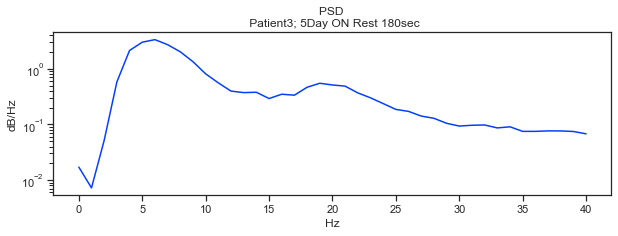

In [28]:
plt.figure(figsize=(10, 3))
lfp.show_psd([0, 40], log=True)

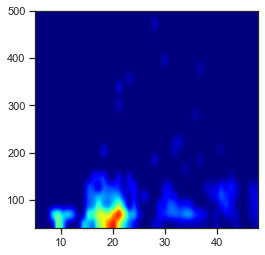

In [29]:
plt.figure(figsize=(4, 4))
comodulogram(pac.pac_matrix, pac.beta_params, pac.hfo_params, pac.pvalues, significant=True)

Based on the PAC comodulogram it is expected to see:
- 20->40 Hz (1:2) phase locking
- 9->...Hz harmonics
- 

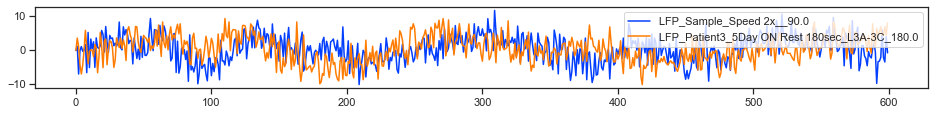

In [30]:
plt.figure(figsize=(16, 1.5))
LFP(lfp.data[::2], condition="Speed 2x").plot(0, 0.3)
lfp.plot(0, 0.3)
plt.legend()

Maybe we will observe non-sinusoidality??

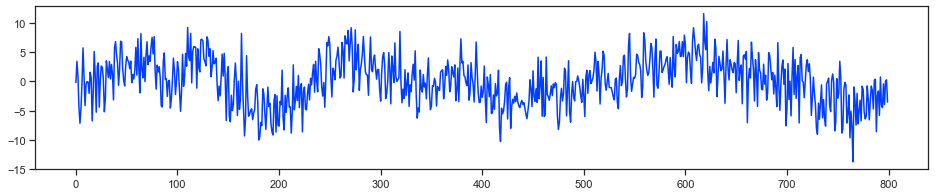

In [31]:
plt.figure(figsize=(16, 3))
lfp.plot(0, 0.4)

Text(0.5, 1.0, '10->20 Hz')

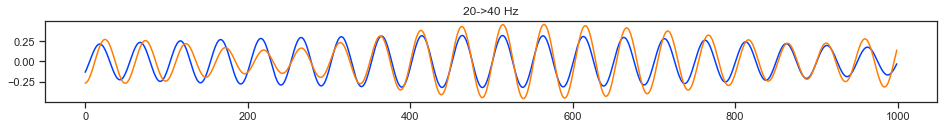

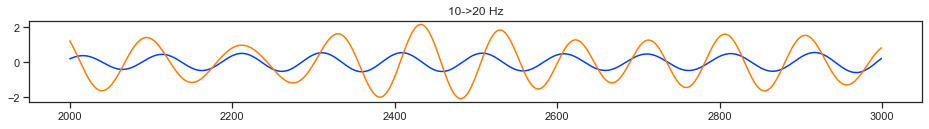

In [32]:
plt.figure(figsize=(16, 1.5))
lfp.bp_filter(39, 41, filter_order=2).plot(0, 0.5)
LFP(lfp.bp_filter(19, 21, filter_order=2).data[::2], condition="Speed 2x").plot(0, 0.5)
plt.title("20->40 Hz")

#plt.legend()

plt.figure(figsize=(16, 1.5))
lfp.bp_filter(19, 21, filter_order=2).normalize().plot(1, 1.5)
LFP(lfp.bp_filter(9, 11, filter_order=2).data[::2], condition="Speed 2x").normalize().plot(1, 1.5)
plt.title("10->20 Hz")

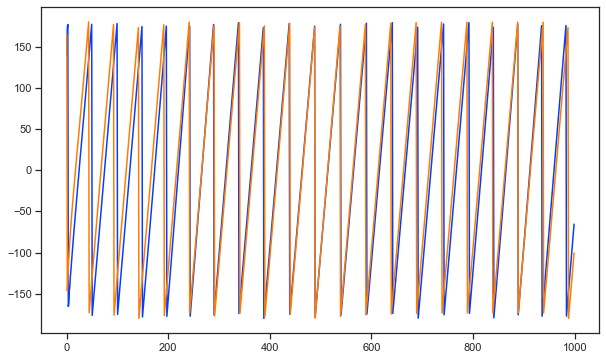

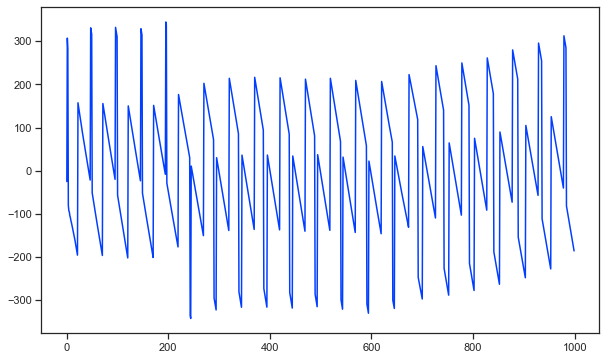

In [72]:
lfp20 = lfp.bp_filter(19, 21, filter_order=2)
lfp40 = lfp.bp_filter(39, 41, filter_order=2)
lfp60 = lfp.bp_filter(59, 61, filter_order=2)

plt.plot(extract_phase(lfp20.data[::2])[0:1000])
plt.plot(extract_phase(lfp40.data)[0:1000])
plt.show()

phase_diff = (extract_phase(lfp20.data[::2]) - extract_phase(lfp40.data)[::2])
plt.plot(phase_diff[:1000])

(array([ 3256., 10247., 19188., 25157., 31957., 32729., 25763., 16856.,
        10820.,  4027.]),
 array([-359.68695891, -287.83295082, -215.97894273, -144.12493464,
         -72.27092655,   -0.41691846,   71.43708963,  143.29109772,
         215.14510581,  286.9991139 ,  358.85312199]),
 <BarContainer object of 10 artists>)

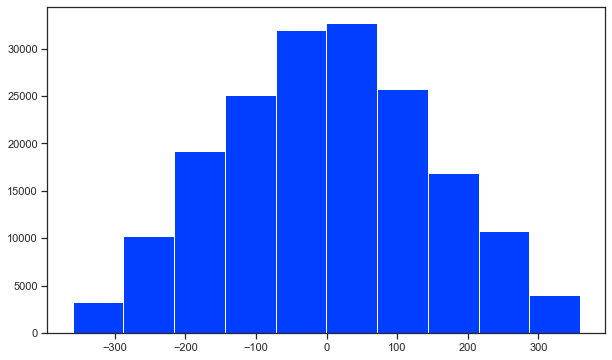

In [34]:
plt.hist(phase_diff)

In [73]:
distr = np.histogram(phase_diff, bins=np.arange(-180, 200, 20))[0]
distr = distr / distr.sum()
N = len(distr)
S = entropy(distr)
S_max = np.log(N)

print(S)
print(S_max)
print((S_max - S)/S_max)

2.873209420784504
2.8903717578961645
0.005937761142584918


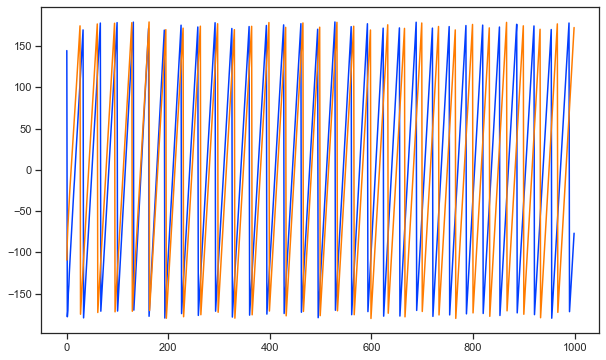

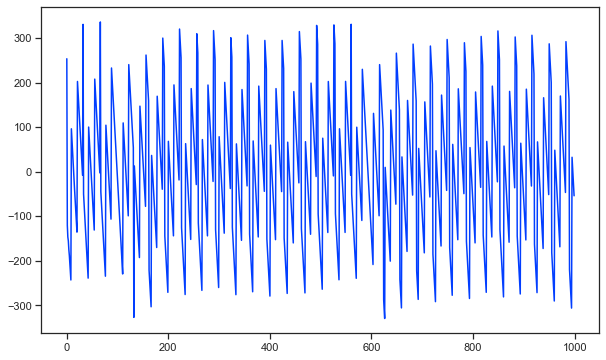

In [39]:
lfp20 = lfp.bp_filter(19, 21, filter_order=2)
lfp40 = lfp.bp_filter(39, 41, filter_order=2)
lfp60 = lfp.bp_filter(59, 61, filter_order=2)

plt.plot(extract_phase(lfp20.data[::3])[0:1000])
plt.plot(extract_phase(lfp60.data)[0:1000])
plt.show()

phase_diff = (extract_phase(lfp20.data[::3]) - extract_phase(lfp60.data)[::3])
plt.plot(phase_diff[:1000])

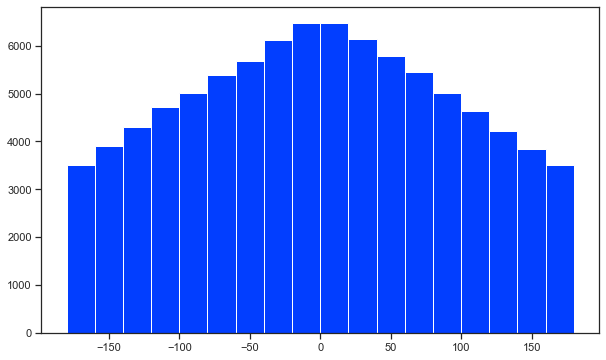

In [59]:
plt.hist(phase_diff, bins=np.arange(-180, 200, 20))

In [71]:


distr = np.histogram(phase_diff, bins=np.arange(-180, 200, 20))[0]
distr = distr / distr.sum()
N = len(distr)
S = entropy(distr)
S_max = np.log(N)

print(S)
print(S_max)
print((S_max - S)/S_max)

2.871699348132847
2.8903717578961645
0.006460210425287556
